# Accessing raw data

Most users of the synaptic physiology dataset should find that our sqlite database files contain all of the processed and analyzed data they need. In a few cases, however, it may be desirable to load raw data from our original NWB files. These files contain multichannel recordings that describe all electrical stimuli applied during an experiment.

To start, pick an experiment from our database:

In [1]:
from aisynphys.database import SynphysDatabase

# load the latest version of the small database
db = SynphysDatabase.load_current('small')

# arbitrarily pick a single experiment
expt = db.experiment_from_ext_id('1537226662.484')

print(f"Electrode IDs with synapses in experiment {expt.ext_id}:")
print("   pre -> post")
for pair in expt.pair_list:
    if pair.has_synapse:
        print(f"    {pair.pre_cell.electrode.device_id}      {pair.post_cell.electrode.device_id}")

Electrode IDs with synapses in experiment 1537226662.484:
   pre -> post
    0      4
    1      4
    7      0


Above, we can see that there are 3 detected synapses in this chosen experiment, and that the postsynaptic recordings appear on electrodes 0 and 4.

The `expt` object here can be used to access any information stored about the experiment in the database, including analyzed cell and synapse properties. In this tutorial, however, we want to go back to the raw data that was used to generate these properties. To access the raw data, use `expt.data`: 

In [2]:
# download NWB file (if needed) and load the data
data = expt.data

print(data)

  /home/luke/ai_synphys_cache/raw_data_files/1537226662.484/data.nwb
  [####################]  100.00% (1.72 GB / 1.7 GB)  0.000 B/s   remaining
  done.
<MultiPatchDataset /home/luke/ai_synphys_cache/raw_data_files/1537226662.484/data.nwb>


Accessing `expt.data` causes the NWB file for this experiment to be downloaded (if it hasn't already) and stored in a cache location on your local drive. The file can now be opened from this location by any HDF5 tools. However, we strongly recommend using the interface provided by `expt.data` to read these files, since they will handle correctly parsing the file structure and metadata within:

### Loading traces and metadata fom NWB

The `data` object contains attributes and methods needed to access sweeps, test pulses, and metadata.
(Note: use `help(data)` to get information on the methods and attributes available from here).

In [3]:
# how many sweeps in this dataset?
len(data.contents)

115

There are 115 sweeps recorded in this experiment. Let's pick an arbitrary sweep to inspect:

In [4]:
# select an arbitrary sweep
sweep = data.contents[20]

# which devices (electrodes 0-7) participated in this sweep?
sweep.devices

[0, 1, 2, 3, 4, 5, 7]

In [5]:
# print some data about the stimulus and recordings on each electrode:
for dev_id in sweep.devices:
    recording = sweep[dev_id]
    print(recording)

<MultiPatchProbe device:0 mode=IC holding=-29 20.0 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:1 mode=IC holding=-698 20.1 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:2 mode=IC holding=-16 20.2 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:3 mode=IC holding=2 20.3 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:4 mode=IC holding=30 20.4 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:5 mode=IC holding=-9 20.5 stim=PulseTrain_20Hz_DA_0>
<MultiPatchProbe device:7 mode=IC holding=-18 20.7 stim=PulseTrain_20Hz_DA_0>


These recordings were done in current clamp mode, running an STP induction stimulus with 20Hz pulse trains.

We can also inspect the stimulus metadata for each recording:

In [6]:
# select just the recording for electrode 0
recording = sweep[0]

# A stimulus is a combination of stimulus items--in this case, a holding current,
# square pulses, and pulse trains.
recording.stimulus.items

(<Offset "holding current" 0x7f4c858e91c0>,
 <SquarePulse "test pulse" 0x7f4c8673afd0>,
 <SquarePulse "Epoch 0" 0x7f4d3c5ad2b0>,
 <SquarePulseTrain "Epoch 1" 0x7f4c858e92b0>,
 <SquarePulse "Epoch 2" 0x7f4c858e94f0>,
 <SquarePulseTrain "Epoch 3" 0x7f4c858e9970>,
 <SquarePulse "Epoch 4" 0x7f4c858e9a00>)

In [7]:
# The stimulus above contains two pulse trains:
pt1 = recording.stimulus.items[3]
pt2 = recording.stimulus.items[5]
for i,pt in enumerate((pt1, pt2)):
    print(f"Pulse train {i} (starts at {pt.start_time*1000:0.2f} ms): "
          f"{pt.n_pulses} x {pt.pulse_duration*1000} ms pulses "
          f"@ {1/pt.interval} Hz, {pt.amplitude * 1e12} pA")


Pulse train 0 (starts at 1025.00 ms): 8 x 3.0 ms pulses @ 20.0 Hz, 1300.0 pA
Pulse train 1 (starts at 1628.00 ms): 4 x 3.0 ms pulses @ 20.0 Hz, 1300.0 pA


Now let's access the recorded time-series data.
Each recording contains two channels of data:
* `primary` contains the recording from the primary channel of the amplifier
* `command` contains the command values that were sent to the amplifier 

In [8]:
print("Recording electrode ID:", recording.device_id)
print("Recording clamp mode:", recording.clamp_mode)
print("Recording channels:", recording.channels)
print("  primary units:", recording['primary'].units)
print("  command units:", recording['command'].units)

Recording electrode ID: 0
Recording clamp mode: ic
Recording channels: ['primary', 'command']
  primary units: V
  command units: A


Let's plot the raw data:

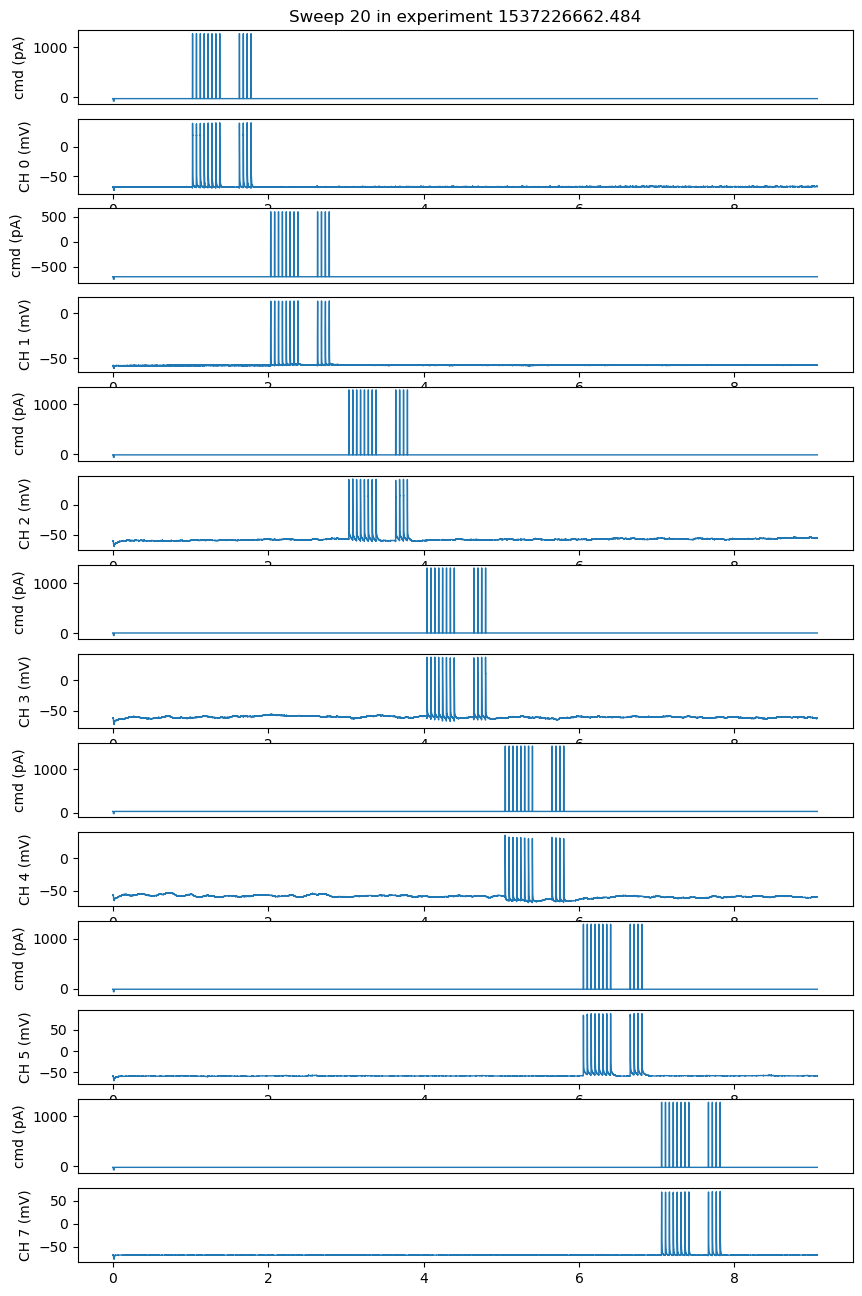

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(len(sweep.devices) * 2, 1, figsize=(10, 16))

for i, dev_id in enumerate(sweep.devices):
    recording = sweep[dev_id]
    command = recording['command']
    ax[i*2].plot(command.time_values, command.data * 1e12, linewidth=1.0)
    ax[i*2].set_ylabel('cmd (pA)')
    ax[i*2].axes.xaxis.set_visible(False)

    primary = recording['primary']
    ax[i*2+1].plot(primary.time_values, primary.data * 1e3, linewidth=1.0)
    ax[i*2+1].set_ylabel(f'CH {dev_id} (mV)')

ax[0].set_title(f"Sweep {sweep.key} in experiment {expt.ext_id}");
    

## Where to get more information

Most of the objects we have loaded here are self-documented, so calling `help()` on the object should provide useful information: 

In [10]:
help(data)

Help on MultiPatchDataset in module aisynphys.data.data object:

class MultiPatchDataset(neuroanalysis.miesnwb.MiesNwb)
 |  MultiPatchDataset(filename)
 |  
 |  Extension of neuroanalysis data abstraction layer to include
 |  multipatch-specific metadata.
 |  
 |  Method resolution order:
 |      MultiPatchDataset
 |      neuroanalysis.miesnwb.MiesNwb
 |      neuroanalysis.data.dataset.Dataset
 |      neuroanalysis.data.dataset.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  create_sync_recording(self, sweep_id)
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from neuroanalysis.miesnwb.MiesNwb:
 |  
 |  __enter__(self)
 |  
 |  __exit__(self, *args)
 |  
 |  __getstate__(self)
 |  
 |  __init__(self, filename)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Return repr(self).
 |  
 |  close(self)
 |  
 |  notebook(self)
 |      Return compiled data from

In [11]:
help(recording)

Help on MultiPatchProbe in module aisynphys.data.data object:

class MultiPatchProbe(MultiPatchRecording)
 |  MultiPatchProbe(recording)
 |  
 |  A 12-pulse stimulus/response used to probe for synaptic connections.
 |  
 |  Method resolution order:
 |      MultiPatchProbe
 |      MultiPatchRecording
 |      neuroanalysis.miesnwb.MiesRecording
 |      neuroanalysis.data.dataset.PatchClampRecording
 |      neuroanalysis.data.dataset.Recording
 |      neuroanalysis.data.dataset.Container
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  stim_params(self)
 |      Return induction frequency and recovery delay.
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from MultiPatchRecording:
 |  
 |  __getattr__(self, attr)
 |  
 |  __init__(self, recording)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __len__(self)
 |  
 |  ----------------------------------------------------------------------
 | 

In [12]:
help(recording['primary'])

Help on MiesTSeries in module neuroanalysis.miesnwb object:

class MiesTSeries(neuroanalysis.data.dataset.TSeries)
 |  MiesTSeries(recording, chan, units=None)
 |  
 |  A homogeneous time series data set. 
 |  
 |  This is a representation of a single stream of data recorded over time. The
 |  data must be representable as a single N-dimensional array where the first
 |  array axis is time. 
 |  
 |  Examples:
 |  
 |  * A membrane potential recording from a single current-clamp headstage
 |  * A video stream from a camera
 |  * A digital trigger waveform
 |  
 |  TSeries may specify units, a starting time, and either a sample period / sample rate
 |  or an array of time values, one per sample.
 |  
 |  Parameters
 |  ----------
 |  data : array | None
 |      Array of data contained in this TSeries where the first axis is time.
 |  dt : float | None
 |      Optional value specifying the time difference between any two adjacent samples
 |      in the data; inverse of *sample_rate*. See

In [13]:
help(recording.stimulus.items[3])

Help on SquarePulseTrain in module neuroanalysis.stimuli object:

class SquarePulseTrain(Stimulus)
 |  SquarePulseTrain(start_time, n_pulses, pulse_duration, amplitude, interval, description='square pulse train', units=None, parent=None)
 |  
 |  A train of identical, regularly-spaced square pulses.
 |  
 |  Parameters
 |  ----------
 |  start_time : float
 |      The starting time of the first pulse in the train, relative to the start time of the parent
 |      stimulus.
 |  n_pulses : int
 |      The number of pulses in the train.
 |  pulse_duration : float
 |      The duration in seconds of a single pulse.
 |  amplitude : float
 |      The amplitude of a single pulse.
 |  interval : float
 |      The time in seconds between the onset of adjacent pulses.
 |  description : str
 |      Optional string describing the stimulus.
 |  units : str | None
 |      Optional string describing the units of values in the stimulus.
 |  
 |  Method resolution order:
 |      SquarePulseTrain
 |      